<a href="https://colab.research.google.com/github/Hernanros/Y_Data_DL/blob/HW%234-answers/%5BHW%234%5DSuper_resulutation_FCN/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone -b HW#4-answers https://github.com/Hernanros/Y_Data_DL DL-Branch


Cloning into 'DL-Branch'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 338 (delta 51), reused 38 (delta 21), pack-reused 250
Receiving objects: 100% (338/338), 580.79 MiB | 35.47 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [0]:
% cd /content/DL-Branch/[HW#4]Super_resulutation_FCN

/content/DL-Branch/[HW#4]Super_resulutation_FCN


In [0]:
import urllib
import tarfile
import os
import wget
import glob

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tarfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_ssim as ssi
l2 = nn.MSELoss()
l1= nn.L1Loss()
NUM_EPOCHS = 20

from models import model1, model2, model3, model4, model5, model6

#augmentation library
import albumentations as A

%matplotlib inline

In [0]:
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
file_tmp = wget.download(url)
tar = tarfile.open(file_tmp)
tar.extractall()
photos= glob.glob('VOCdevkit/VOC2007/JPEGImages/*.jpg')

In [0]:
sample = []
[sample.append(cv2.imread(photos[ind])) for ind in range(len(photos))]
sample = np.array(sample)
y_large = [cv2.resize(sample[ind] , (288,288)) for ind in range(len(sample))]
y_mid = [cv2.resize(y_large[ind] , (144,144)) for ind in range(len(sample))]
x_train = [cv2.resize(y_large[ind] , (72,72)) for ind in range(len(sample))]

In [0]:
inds = np.random.choice(len(photos),len(photos),False)
first_80_percent = int(.8*len(photos))

X_train, y_mid_train, y_large_train = np.array(x_train)[inds[:first_80_percent]], np.array(y_mid)[inds[:first_80_percent]], np.array(y_large)[inds[:first_80_percent]]

X_test, y_mid_test, y_large_test = np.array(x_train)[inds[first_80_percent:]], np.array(y_mid)[inds[first_80_percent:]], np.array(y_large)[inds[first_80_percent:]]

### loss evaluation
PSNR loss function that evaluates the mean square loss per pixle (l2 loss).<br>
$$PSNR_{l2} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}[I(i,j)-K(i,j)]^2$$
where I is the ground truth and K is the recostructed image<br>

other variations of PSNR loss functions consider using l1 loss (Mean Absolute error) as the loss function<br>
$$ PSNR_{l1} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}|I(i,j)-K(i,j)|$$<br>

SSIM loss is a is a method for predicting the perceived quality of an image, while taking into account an entire patch of the image, and not a pixel to pixel evaluation.

The SSIM index is calculated on various windows of an image. The measure between two windows $x$ and $y$ of common size N×N is:<br>

$$\hbox{SSIM}(x,y)=\frac {(2\mu _{x}\mu _{y}+c_{1})(2\sigma _{xy}+c_{2})}{(\mu _{x}^{2}+\mu _{y}^{2}+c_{1})(\sigma _{x}^{2}+\sigma _{y}^{2}+c_{2})}$$

In [0]:
import pytorch_ssim as ssi
import models.model1 as model1
l2 = nn.MSELoss()
l1= nn.L1Loss()

model = model1.firstmodel()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [0]:
def train_fold_mid(tr_loader,model,criterion,optimizer, num_epochs):
    model.to(device)
    
    training_log =[]

    
    for epoch in range(num_epochs):
      print("started training epoch no. {}".format(epoch+1))
      tr_loss = 0
      for step,batch in enumerate(tr_loader):
            imgs, labels = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(imgs)

            loss = 1-criterion(outputs, labels, window_size=12)
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

      training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })
      
    return training_log

def test_evaluation_mid(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels = labels.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += 1-losses[0](outputs,labels, window_size=12).item()
        loss_mse += losses[1](outputs,labels).item()
        loss_mae += losses[2](outputs,labels).item()
        N += len(batch)
    f,ax = plt.subplots(batch[0].shape[0], 3 ,figsize = (5*batch[0].shape[0],15) )
    
    imgs , labels= imgs.cpu().detach().numpy().astype(int), labels.cpu().detach().numpy().astype(int)
    outputs_hats = np.abs(outputs.cpu().detach().numpy().astype(int))

    for i in range(batch[0].shape[0]):
      orig_x , orig_y= imgs[i], labels[i]
      outputs = outputs_hats[i]
      val=0
      ax[i,val].imshow(orig_x)
      ax[i,val].set_title('original 72*72 image')

      val+=1
      ax[i,val].imshow(outputs)
      ax[i,val].set_title('model output')
      
      val+=1
      ax[i,val].imshow(orig_y)
      ax[i,val].set_title('target image')
      
    print ("test set results:\n SSIM:{}\tL1 loss(MSE):{}\tL2 loss(MAE):{}".format(loss_ssim/N, loss_mse/N, loss_mae/N))

In [0]:
train_fold_mid(train_loader,model,criterion,optimizer,num_epochs= 50)

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20
started training epoch no. 21
started training epoch no. 22
started training epoch no. 23
started training epoch no. 24
started training epoch no. 25
started training epoch no. 26
started training epoch no. 27
started training epoch no. 28
started training epoch no. 29
started training epoch no. 30
started training epoch no. 31
started training epoch no. 32
started training epoch no. 33
started training epoch no. 34
started training e

[{'epoch': 0, 'train_loss': 0.32442428469657897},
 {'epoch': 1, 'train_loss': 0.17047567367553712},
 {'epoch': 2, 'train_loss': 0.13736757636070251},
 {'epoch': 3, 'train_loss': 0.12385992407798767},
 {'epoch': 4, 'train_loss': 0.11611926555633545},
 {'epoch': 5, 'train_loss': 0.11168603897094727},
 {'epoch': 6, 'train_loss': 0.10910292863845825},
 {'epoch': 7, 'train_loss': 0.10759073793888092},
 {'epoch': 8, 'train_loss': 0.1054377943277359},
 {'epoch': 9, 'train_loss': 0.1038973718881607},
 {'epoch': 10, 'train_loss': 0.10274836122989654},
 {'epoch': 11, 'train_loss': 0.1010404348373413},
 {'epoch': 12, 'train_loss': 0.10031000673770904},
 {'epoch': 13, 'train_loss': 0.0997013121843338},
 {'epoch': 14, 'train_loss': 0.0995184451341629},
 {'epoch': 15, 'train_loss': 0.09850925505161286},
 {'epoch': 16, 'train_loss': 0.09760413765907287},
 {'epoch': 17, 'train_loss': 0.09710213243961334},
 {'epoch': 18, 'train_loss': 0.09661841690540314},
 {'epoch': 19, 'train_loss': 0.096151253581047

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test set results:
 SSIM:0.04073411226272583	L1 loss(MSE):314.4563293457031	L2 loss(MAE):8.1354474067688


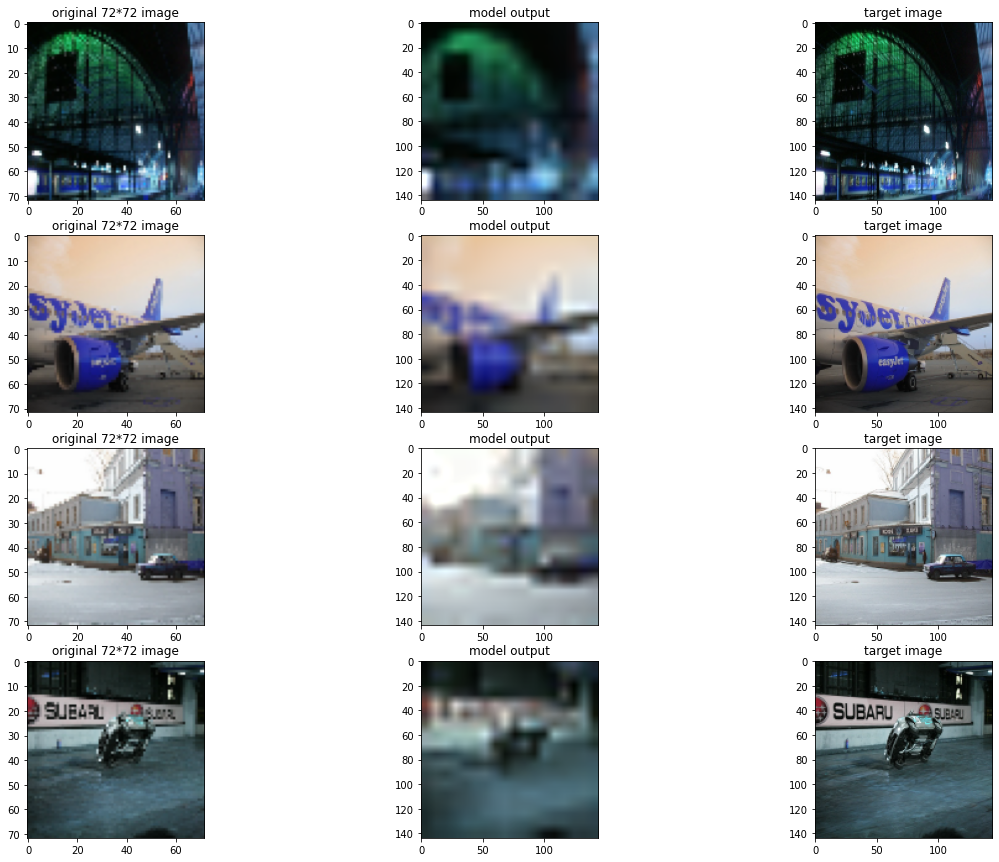

In [0]:
test_evaluation_mid(test_loader,model,[criterion,l2,l1])

In [0]:
 class DS_mid(Dataset):
    def __init__(self,df,labels, transforms=None):
        super().__init__()
        self.df=df
        self.labels=labels
        self.transforms=transforms
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img= self.df[idx]
        label = self.labels[idx]        
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img,label
    
class DS_both(Dataset):
    def __init__(self,df,labels_mid,labels_large, transforms=None):
        super().__init__()
        self.df=df
        self.labels_mid=labels_mid
        self.labels_large=labels_large
        self.transforms=transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img= self.df[idx]
        labels_mid = self.labels_mid[idx]   
        labels_large = self.labels_large[idx]        
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img,labels_mid,labels_large


In [0]:
def train_fold_mid(tr_loader,model,criterion,optimizer, num_epochs):
    model.to(device)
    
    training_log =[]

    
    for epoch in range(num_epochs):
        print("started training epoch no. {}".format(epoch+1))
        tr_loss = 0
        for step,batch in enumerate(tr_loader):
            imgs, labels = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(imgs)

            loss = 1-criterion(outputs, labels, window_size=12)
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

        training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })

    return training_log

def test_evaluation_mid(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels = labels.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += 1-losses[0](outputs,labels, window_size=12).item()
        loss_mse += losses[1](outputs,labels).item()
        loss_mae += losses[2](outputs,labels).item()
        N += len(batch)
    # f,ax = plt.subplots(batch[0].shape[0], 3 ,figsize = (5*batch[0].shape[0],15) )
    
    imgs , labels= imgs.cpu().detach().numpy().astype(int), labels.cpu().detach().numpy().astype(int)
    outputs_hats = np.abs(outputs.cpu().detach().numpy().astype(int))
    
#     for i in range(batch[0].shape[0]):

#         orig_x , orig_y= imgs[i], labels[i]
#         outputs = outputs_hats[i]
#         val=0
#         ax[i,val].imshow(orig_x)
#         ax[i,val].set_title('original 72*72 image')

#         val+=1
#         ax[i,val].imshow(outputs)
#         ax[i,val].set_title('model output')

#         val+=1
#         ax[i,val].imshow(orig_y)
#         ax[i,val].set_title('target image')
    test_loss = {'ssim':loss_ssim/N,"mse": loss_mse/N,"mae": loss_mae/N}
    
    return imgs, labels, outputs_hats, test_loss 
#   print ("test set results:\n SSIM:{}\tL1 loss(MSE):{}\tL2 loss(MAE):{}".format(loss_ssim/N, loss_mse/N, loss_mae/N))

In [0]:
def train_fold_both(tr_loader,model,criterion,optimizer, num_epochs):
    model.to(device)
    
    training_log =[]
    
    for epoch in range(num_epochs):
        print("started training epoch no. {}".format(epoch+1))
        tr_loss = 0
        for step,batch in enumerate(tr_loader):
            imgs, labels_mid, labels_large = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels_mid,labels_large = labels_mid.to(device,dtype=torch.float32), labels_large.to(device,dtype=torch.float32)
            outputs_1, outputs_2 = model(imgs)

            loss = (1-criterion(outputs_1, labels_mid, window_size=12)) + (1-criterion(outputs_2, labels_large, window_size=12))
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

        training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })

    return training_log


def test_evaluation_both(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels_mid, labels_large = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels_mid, labels_large = labels_mid.to(device,dtype=torch.float32), labels_large.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += (1-losses[0](outputs[0],labels_mid, window_size=12).item()) + (1-losses[0](outputs[1],labels_large, window_size=12).item())
        loss_mse += losses[1](outputs[0],labels_mid).item() + (losses[1](outputs[1],labels_large).item())
        loss_mae += losses[2](outputs[0],labels_mid).item() + losses[2](outputs[1],labels_large).item()
        N += len(batch)
    # f,ax = plt.subplots(batch[0].shape[0], 5 ,figsize = (5*batch[0].shape[0],25) )
    
    imgs , labels_mid , labels_large = imgs.cpu().detach().numpy().astype(int), labels_mid.cpu().detach().numpy().astype(int), labels_large.cpu().detach().numpy().astype(int)
    outputs_small,outputs_large = np.abs(outputs[0].cpu().detach().numpy().astype(int)),np.abs(outputs[1].cpu().detach().numpy().astype(int))
    test_loss = {'ssim':loss_ssim/N,"mse": loss_mse/N,"mae": loss_mae/N}

#     for i in range(batch[0].shape[0]):
#         orig_x , orig_mid, orig_large= imgs[i], labels_mid[i], labels_large[i]
#         output1 = outputs_small[i]
#         output2 = outputs_large[i]
#         val=0
#         ax[i,val].imshow(orig_x)
#         ax[i,val].set_title('original 72*72 image')

#         val+=1
#         ax[i,val].imshow(output1)
#         ax[i,val].set_title('model output small')

#         val+=1
#         ax[i,val].imshow(orig_mid)
#         ax[i,val].set_title('target image(mid)')

#         val+=1
#         ax[i,val].imshow(output2)
#         ax[i,val].set_title('model output large')


#         val+=1
#         ax[i,val].imshow(orig_large)
#         ax[i,val].set_title('target image(large)')
    
    return imgs , labels_mid , labels_large, outputs_small, outputs_large, test_loss
#     print ("test set results:\n SSIM:{}\tL1 loss(MSE):{}\tL2 loss(MAE):{}".format(loss_ssim/N, loss_mse/N, loss_mae/N))
        

## MODEL 1

In [0]:
train_set = DS_mid(X_train,y_mid_train)
test_set= DS_mid(X_test,y_mid_test)

train_loader=DataLoader(dataset= train_set, batch_size = 4, shuffle = True, num_workers = 2)
test_loader=DataLoader(dataset= test_set, batch_size = 4, shuffle = True, num_workers = 2)

In [0]:
model = model1.firstmodel()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


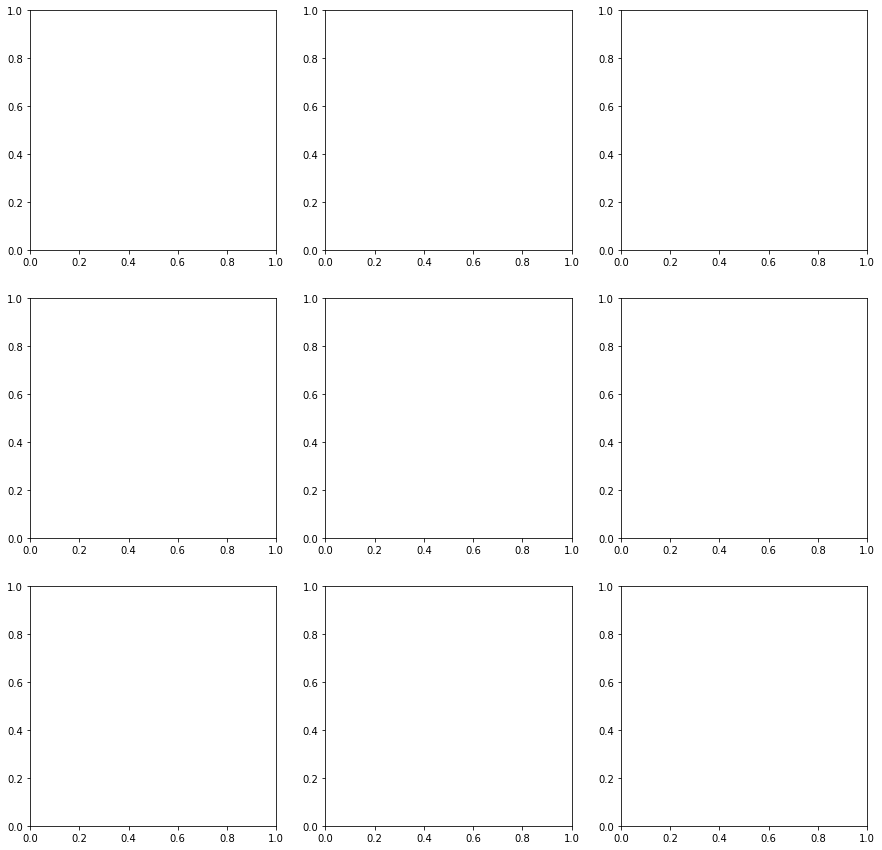

In [0]:
m1_train_log = train_fold_mid(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m1_imgs, m1_labels, m1_output_hats, m1_test_loss = test_evaluation_mid(test_loader,model,[criterion,l2,l1])

## MODEL 2

In [0]:
train_set = DS_both(X_train,y_mid_train,y_large_train)
test_set= DS_both(X_test,y_mid_test, y_large_test)

train_loader=DataLoader(dataset= train_set, batch_size = 4, shuffle = True, num_workers = 2)
test_loader=DataLoader(dataset= test_set, batch_size = 4, shuffle = True, num_workers = 2)

In [0]:
model= model2.second_model()

criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


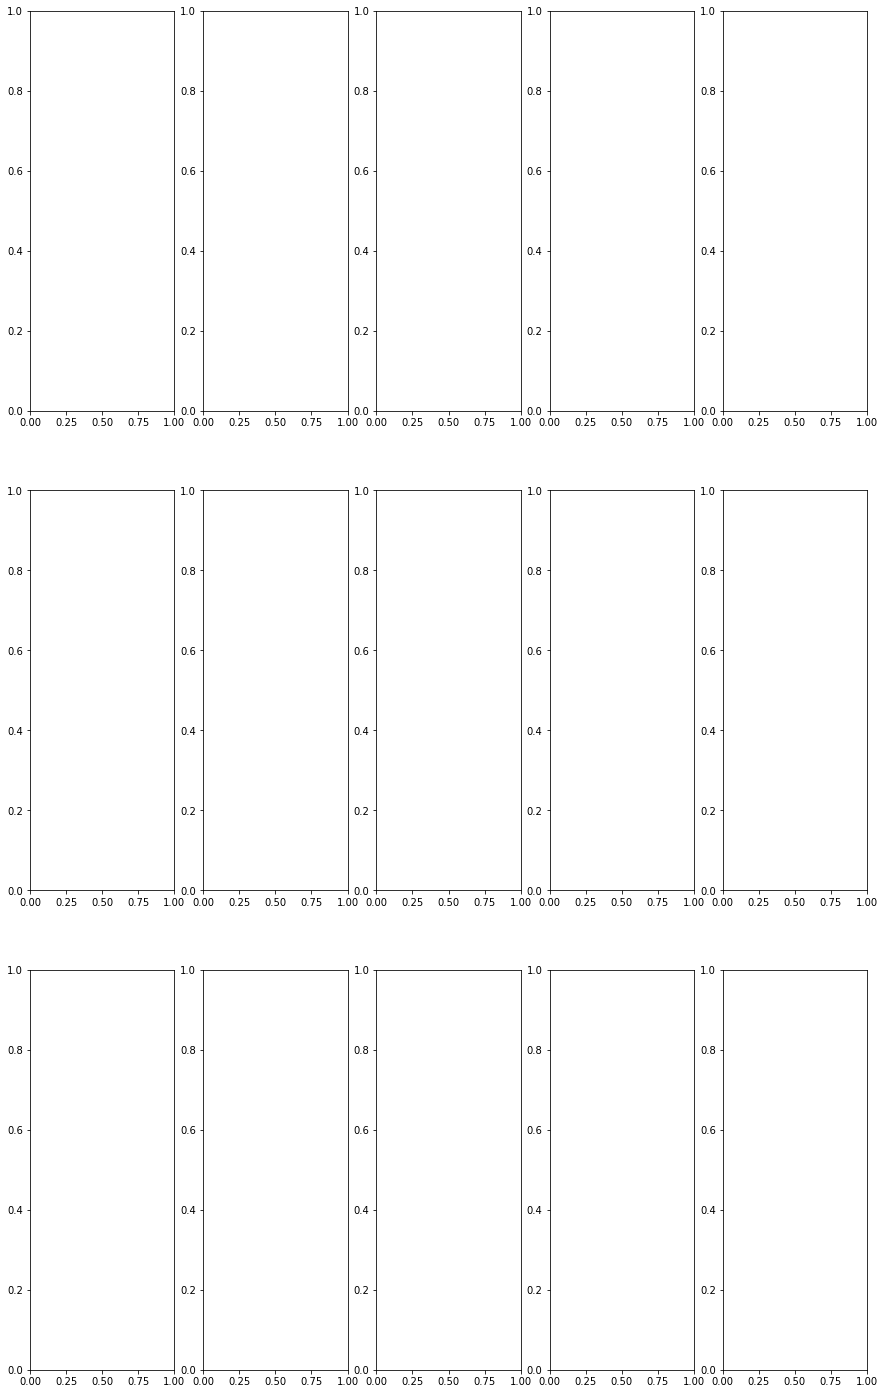

In [0]:
m2_train_log = train_fold_both(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m2_imgs , m2_labels_mid , m2_labels_large, m2_outputs_small, m2_outputs_large, m2_test_loss = test_evaluation_both(test_loader,model,[criterion,l2,l1])

## Model 3

In [0]:
model= model3.third_model()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


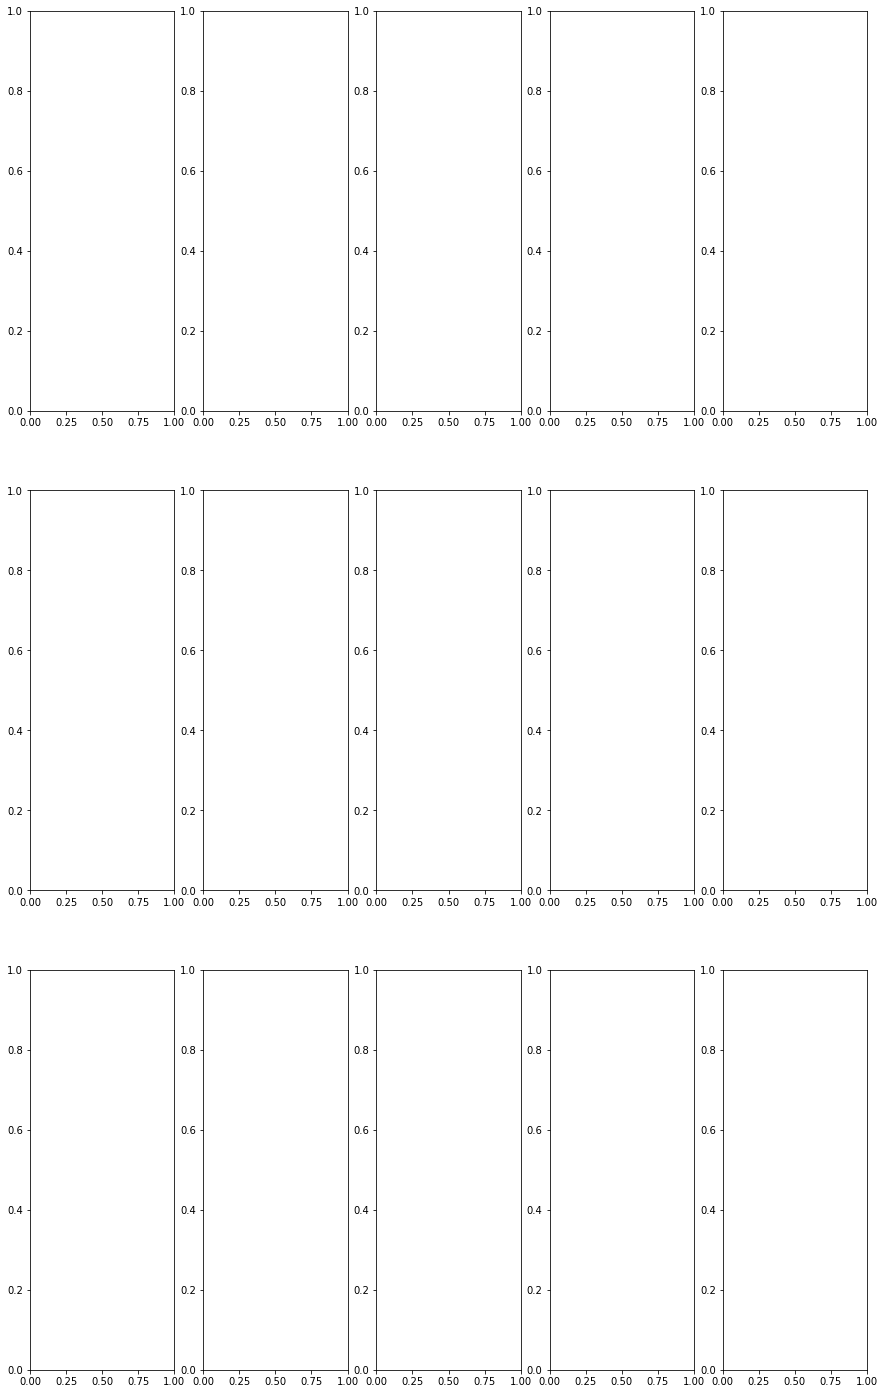

In [0]:
m3_train_log = train_fold_both(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m3_imgs , m3_labels_mid , m3_labels_large, m3_outputs_small, m3_outputs_large, m3_test_loss = test_evaluation_both(test_loader,model,[criterion,l2,l1])

## Model 4

In [0]:
model= model4.fourth_model()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


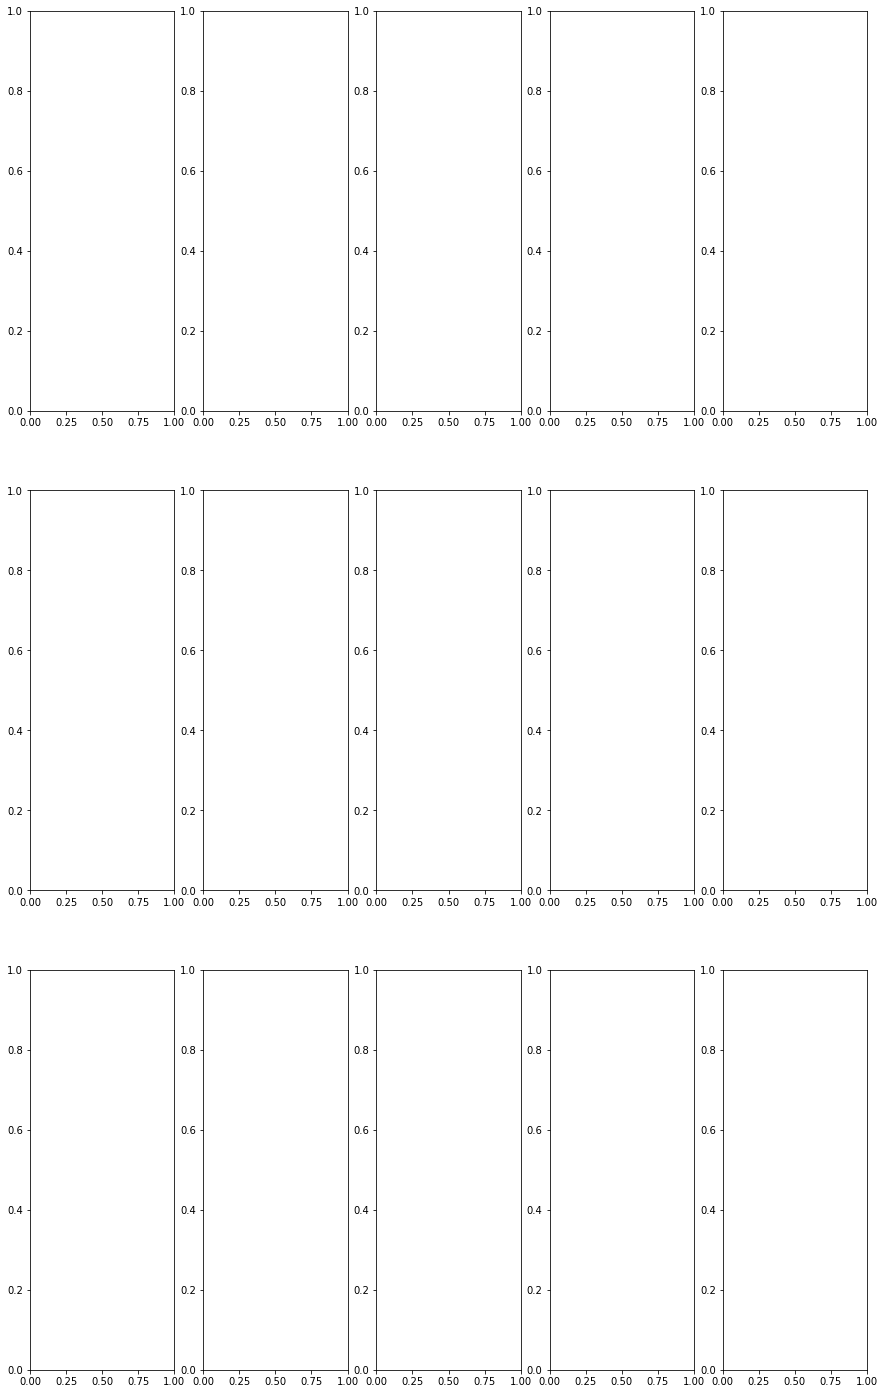

In [0]:
m4_train_log = train_fold_both(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m4_imgs , m4_labels_mid , m4_labels_large, m4_outputs_small, m4_outputs_large, m4_test_loss = test_evaluation_both(test_loader,model,[criterion,l2,l1])

## Model 5

In [0]:
model= model5.fifth_model()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


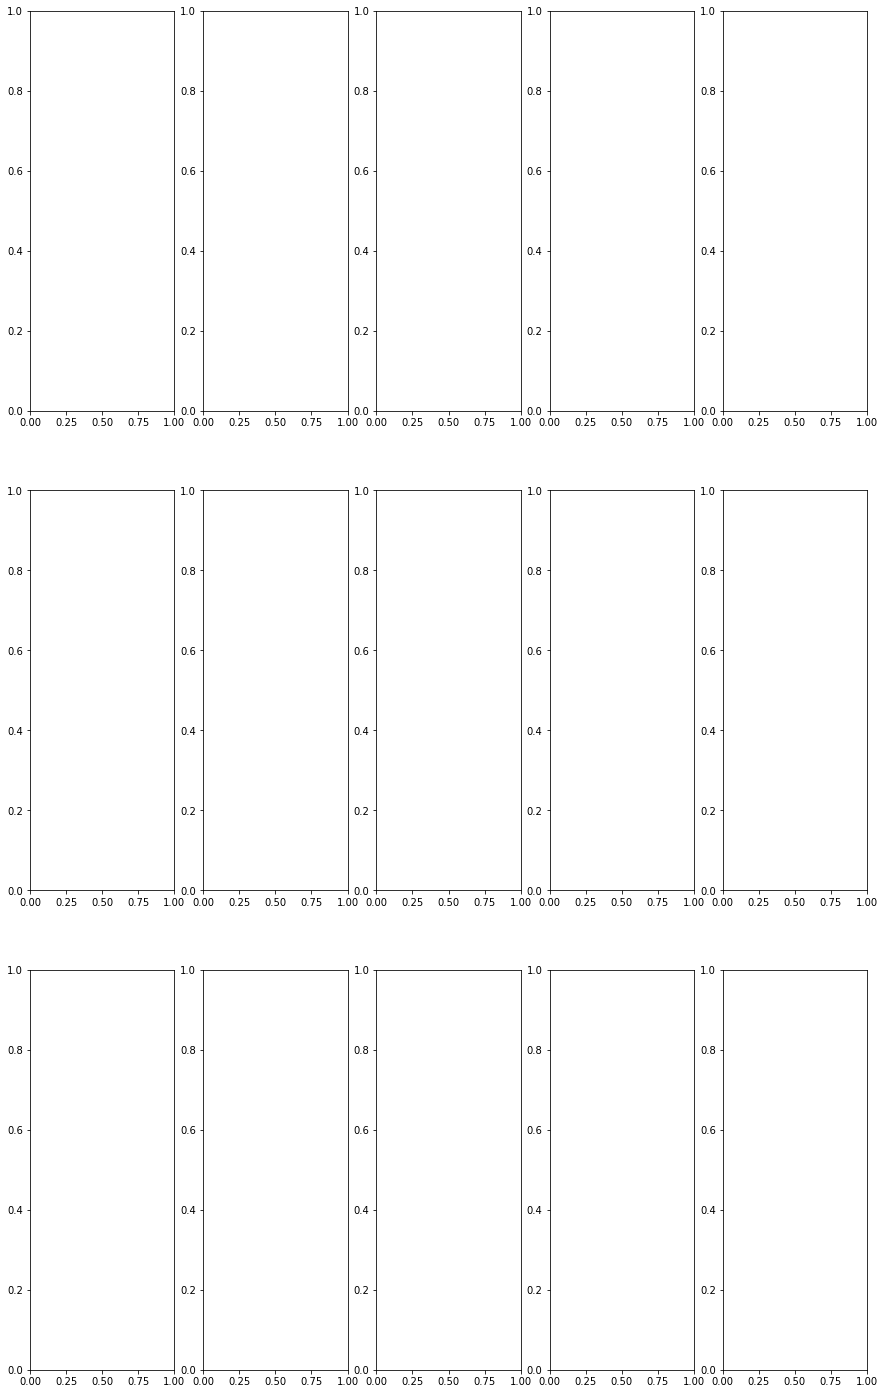

In [0]:
m5_train_log = train_fold_both(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m5_imgs , m5_labels_mid , m5_labels_large, m5_outputs_small, m5_outputs_large, m5_test_loss = test_evaluation_both(test_loader,model,[criterion,l2,l1])

## BONUS - Model 6

In [0]:
model= model6.sixth_model()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

started training epoch no. 1
started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20


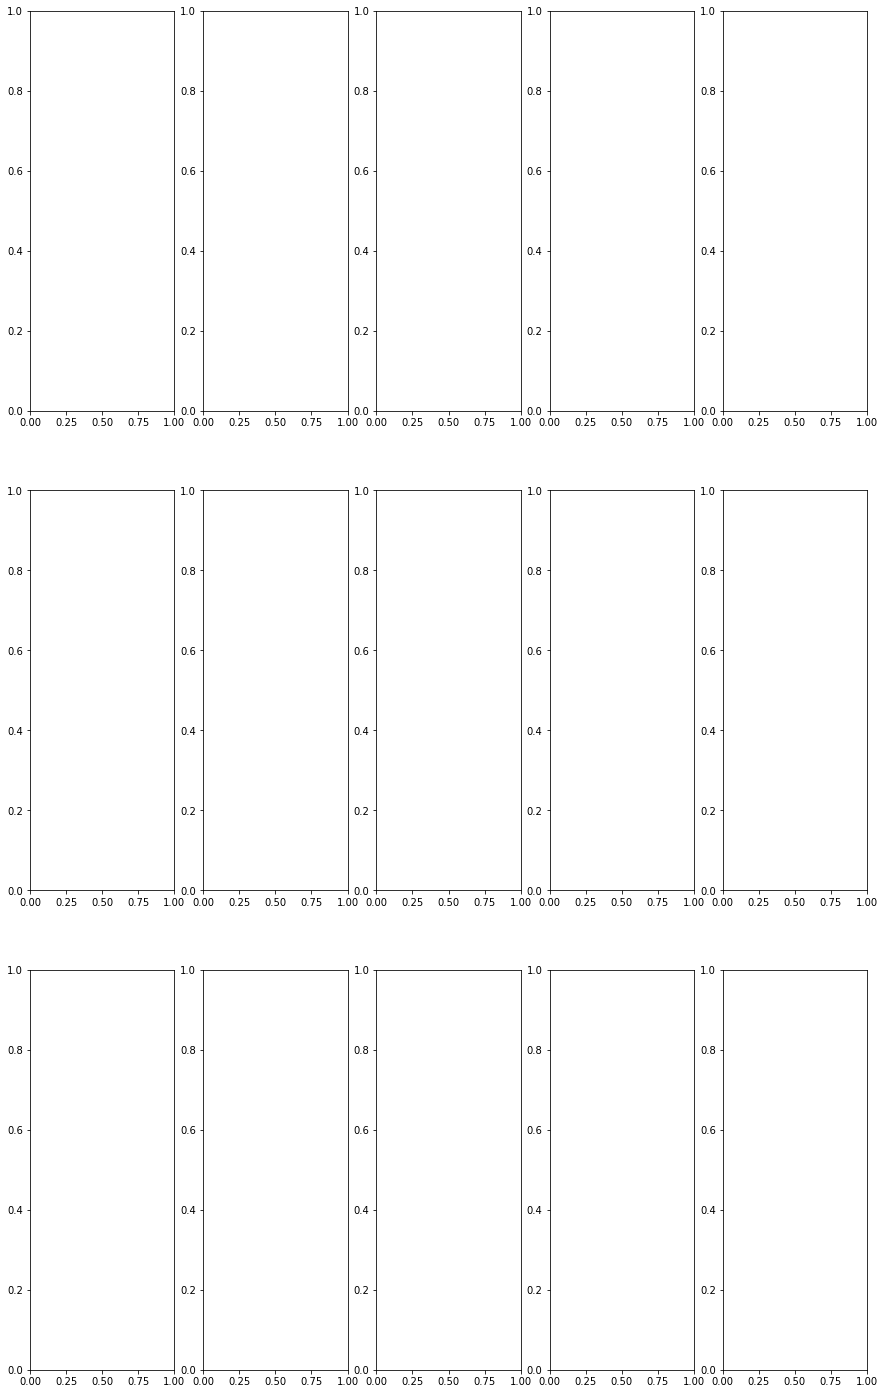

In [0]:
m6_train_log = train_fold_both(train_loader,model,criterion,optimizer,num_epochs= NUM_EPOCHS)
m6_imgs , m6_labels_mid , m6_labels_large, m6_outputs_small, m6_outputs_large, m6_test_loss = test_evaluation_both(test_loader,model,[criterion,l2,l1])

In [0]:
def plot_both(model_name,imgs,labels_mid,outputs_mid,labels_large=None,outputs_large=None):

  num_pics = 1
  for i in range(num_pics):

    
    if labels_large is not None:
      f,ax = plt.subplots(num_pics, 5 ,figsize = (6*imgs.shape[0],4))
    else:
      f,ax = plt.subplots(num_pics, 3 ,figsize = (4*imgs.shape[0],4))

    plt.suptitle(model_name)

    orig_x = imgs[i]
    orig_mid = labels_mid[i]
    output1 = outputs_mid[i]

    if labels_large is not None:
      orig_large = labels_large[i]

    if outputs_large is not None:
      output2 = outputs_large[i]

    val=0
    ax[val].imshow(orig_x)
    ax[val].set_title('original 72*72 image')

    val+=1
    ax[val].imshow(output1)
    ax[val].set_title('model output small')

    val+=1
    ax[val].imshow(orig_mid)
    ax[val].set_title('target image(mid)')

    if labels_large is not None:
        val+=1
        ax[val].imshow(output2)
        ax[val].set_title('model output large')
        
    if outputs_large is not None:
        val+=1
        ax[val].imshow(orig_large)
        ax[val].set_title('target image(large)')

    outPDF = './results/figure_{}_iter_{}.pdf'.format(model_name, NUM_EPOCHS)
    f.savefig(outPDF, dpi=300)
    plt.show()


## REPORT

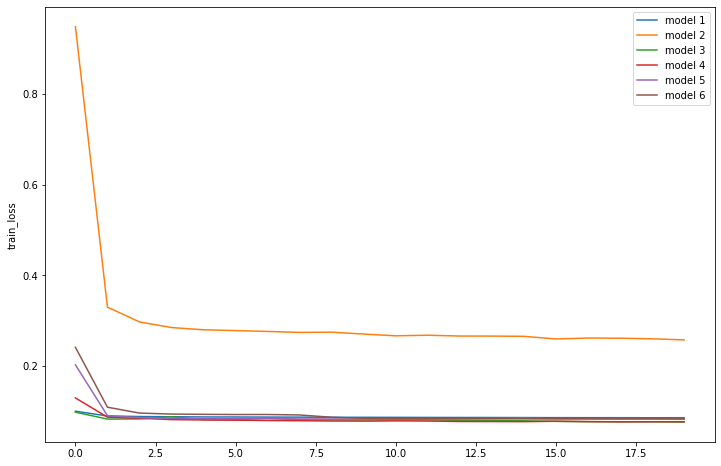

In [0]:
# Graphing the train loss

fig, ax = plt.subplots(figsize=(12,8))

for i in range(1,7):
    train_log = eval("m{}_train_log".format(i))
    train_log = pd.DataFrame(train_log)['train_loss']
    sns_lineplot = sns.lineplot(train_log.index, train_log, label="model {}".format(i))

fig = sns_lineplot.get_figure()
fig.savefig("train_loss_20_iterations.png") 

In [0]:
# Dataframe of PSNR metrics on test loss
m_list = []

m_loss_list = [m1_test_loss, m2_test_loss, m3_test_loss, m4_test_loss, m5_test_loss, m6_test_loss]

for i, m_loss in enumerate(m_loss_list):
  m_loss = list(m_loss.values())
  m_list.append(m_loss)

df = pd.DataFrame(m_list, columns=["ssim","mse","mae"], index= list(range(1,7)))

In [0]:
df.to_csv("Test PSNR - 20 Iterations")

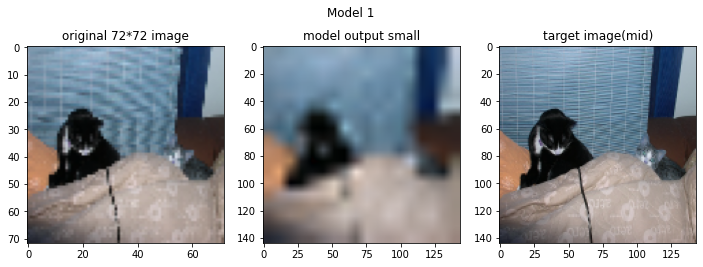

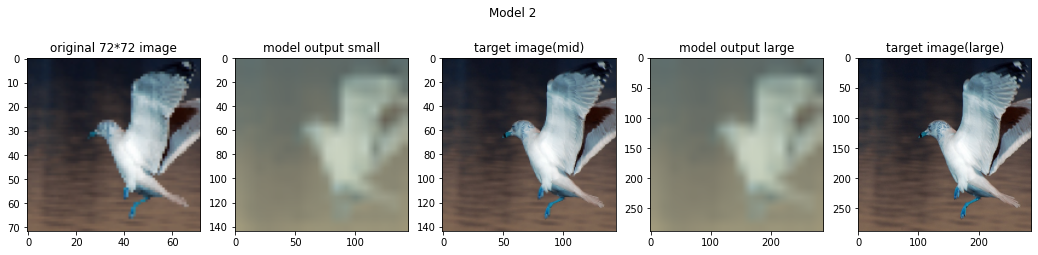

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


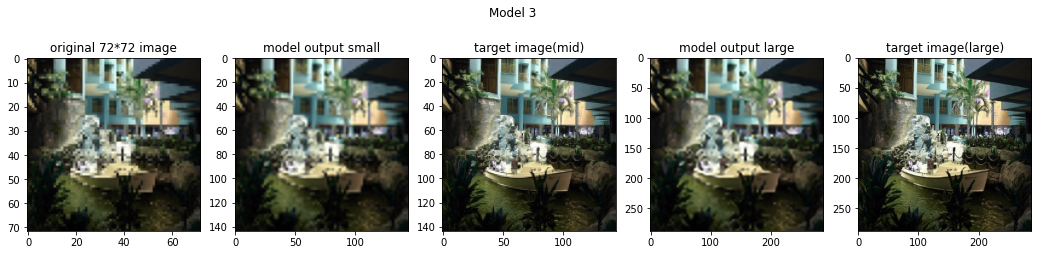

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


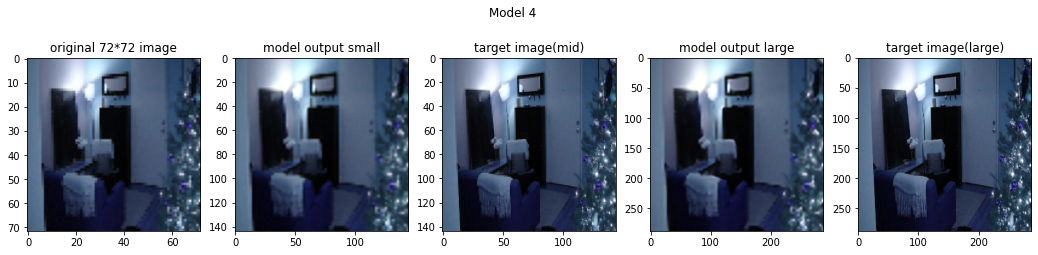

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


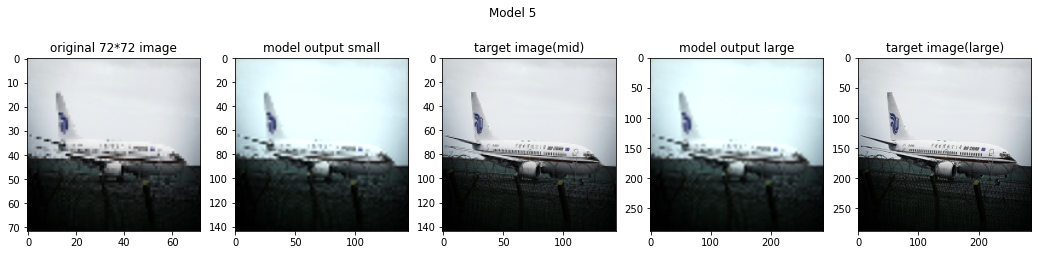

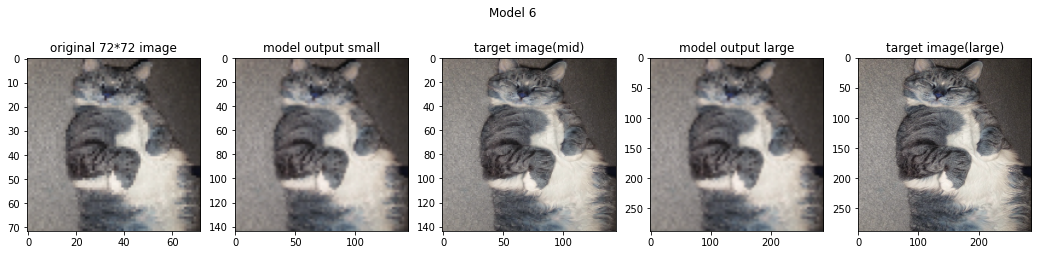

In [0]:
# Show examples of each models output

for i in range(1,7):
    if i == 1:
        m_imgs, m_labels_mid, m_outputs_small = m1_imgs, m1_labels, m1_output_hats
        m_labels_large = m_outputs_large = None
    else:
      m_imgs = eval("m{}_imgs".format(i))
      m_labels_mid = eval("m{}_labels_mid".format(i))
      m_labels_large = eval("m{}_labels_large".format(i))
      m_outputs_small = eval("m{}_outputs_small".format(i))
      m_outputs_large = eval("m{}_outputs_large".format(i))
    model_name = "Model {}".format(i)
    plot_both(model_name,m_imgs,m_labels_mid,m_outputs_small,m_labels_large,m_outputs_large)

# Summary

out of all of the model tested, it appears that the fourth model (dilated convolution blocks) preform the best out of the lot.<br>
with the exception of the second model (the first to introduce 2 outputs), all of the models preformences are more or less similar.<br>
to keep improving on top of these results, maybe we can try using other loss calculations other than SSIM. in some articles that we explored, the calculated loss was the average of traditional methods (l1\l2) with holistic methods such as SSIM.

hyperparameter tuning could also prive to be benificial in this case.